<a href="https://colab.research.google.com/github/umairashrafyo/umairproject/blob/main/CNN_ensemble_learning_with_mnist_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#First, we need to import the required libraries. 
import tensorflow.keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split
import itertools
import math
from sklearn.model_selection import train_test_split, KFold
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop, Adagrad

In [4]:
#After importing the required libraries, we will read the MNIST handwritten data set that is provided publicly in Google Colab as sample data.
#Reading the data
train = pd.read_csv("/content/drive/MyDrive/mnist dataset/train.csv")
test = pd.read_csv("/content/drive/MyDrive/mnist dataset/test.csv")

In [5]:
#Now, we need to specify the training and test sets. It will be done using the below lines of codes. First, we will check the header and then we will identify the required columns
#Training data head
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
#Specifying train and test data
train_X = train.iloc[:,1:]
train_y = train.iloc[:,0]
test = test.iloc[:,1:]

#Shape of the specified data
print(train_X.shape)
print(train_y.shape)
print(test.shape)

(19999, 784)
(19999,)
(9999, 784)


In [7]:
#Now, we will normalize the training and test data
#Normalize the data
train_X = train_X / 255.0
test = test / 255.0

In [8]:
#Reshape image in 3 dimensions (with 1 channel)
train_X = train_X.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)


In [9]:
#Encode labels to one hot vectors
train_y = to_categorical(train_y, num_classes = 10)

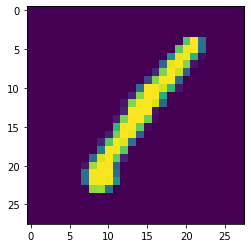

In [10]:
#Sample image
plt.imshow(train_X[0][:,:,0])

In [21]:
#Ensemble Of Convolutional Neural Networks
# Define 10 CNN models
from keras.optimizers import RMSprop, Adam
from keras.layers import DepthwiseConv2D, Reshape, Activation

nets = 10
model = [0] *nets

for j in range(nets):
    model[j] = Sequential()
    #First Layer
    model[j].add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    #Second Layer
    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    #Third layer
    model[j].add(Conv2D(128, kernel_size = 4, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Flatten())
    model[j].add(Dropout(0.4))

    #Output layer
    model[j].add(Dense(10, activation='softmax'))

    # Compile each model
    model[j].compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])

    
print('All Models Defined')


All Models Defined


In [22]:
#We will use the learning rate annealer in this experiment. The learning rate annealer decreases the learning rate after a certain number of epochs if the error rate does not change. Here, through this technique, we will monitor the validation accuracy and if it seems to be a plateau in 3 epochs, it will reduce the learning rate.
#LR Reduction Callback
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction=ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=0, factor=0.5, min_lr=0.00001)

In [23]:
#In the next step, we will train the models that we have defined above.
# train for 20 epochs
# train for 20 epochs
history = [0] * nets
epochs = 20

datagen = ImageDataGenerator(rotation_range=13, zoom_range=0.11, width_shift_range=0.1, height_shift_range=0.1)

datagen.fit(train_X)

for j in range(nets):
    print(f'Individual Net : {j+1}')   
    X_train2, X_val2, Y_train2, Y_val2 = train_test_split(train_X, train_y, test_size = 0.1)
    history[j] = model[j].fit(datagen.flow(X_train2,Y_train2, batch_size=64), epochs = epochs, steps_per_epoch = X_train2.shape[0]//64, validation_data = (X_val2,Y_val2), callbacks=[learning_rate_reduction], verbose=1)

    print("CNN Model {0:d}: Epochs={1:d}, Training accuracy={2:.5f}, Validation accuracy={3:.5f}".format(j+1,epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))


Individual Net : 1
Epoch 1/20
281/281 [==============================] - 80s 279ms/step - loss: 1.4529 - accuracy: 0.5668 - val_loss: 7.0598 - val_accuracy: 0.1025
Epoch 2/20
281/281 [==============================] - 78s 278ms/step - loss: 0.2601 - accuracy: 0.9183 - val_loss: 0.3419 - val_accuracy: 0.8820
Epoch 3/20
281/281 [==============================] - 79s 280ms/step - loss: 0.1526 - accuracy: 0.9535 - val_loss: 0.0444 - val_accuracy: 0.9880
Epoch 4/20
281/281 [==============================] - 79s 281ms/step - loss: 0.1354 - accuracy: 0.9562 - val_loss: 0.0443 - val_accuracy: 0.9865
Epoch 5/20
281/281 [==============================] - 78s 279ms/step - loss: 0.1121 - accuracy: 0.9655 - val_loss: 0.0653 - val_accuracy: 0.9840
Epoch 6/20
281/281 [==============================] - 78s 279ms/step - loss: 0.1003 - accuracy: 0.9683 - val_loss: 0.0313 - val_accuracy: 0.9910
Epoch 7/20
281/281 [==============================] - 78s 278ms/step - loss: 0.0935 - accuracy: 0.9746 - val_lo

In [ ]:
#Result
results = np.zeros( (test.shape[0],10) ) 
for j in range(nets):
    results = results + model[j].predict(test)
 
results = np.argmax(results,axis = 1)

In [ ]:
#Test on result
plt.imshow(test[0][:,:,0])
plt.title(results[0])

In [ ]:
L = 4
W = 4
fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L * W):  
    axes[i].imshow(test[i].reshape(28,28))
    axes[i].set_title(results[i])
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)